In [23]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

class MLBacktester():

    def __init__(self,symbol,start,end,tc):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.model = OneVsOneClassifier(LogisticRegression(C = 1e6, max_iter=100000))
        self.results = None
        self.get_data()

    def __repr__(self):
        return 'MLBacktester(symbol = {}, start = {}, end = {}, tc = {})'.format(self.symbol,self.start,self.end,self.tc)

    def get_data(self):
        raw = pd.read_csv('five_minute_pairs.csv',parse_dates=['time'],index_col='time')
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol:'price'}, inplace=True)
        raw['returns'] = np.log(raw['price']/raw['price'].shift(1))
        self.data = raw

    def split_data(self,start,end):
        data = self.data.loc[start:end].copy()
        return data

    def prepare_features(self,start,end):
        self.data_subset = self.split_data(start,end)
        self.feature_columns = []
        for lag in range(1,self.lags + 1):
            col = 'lag{}'.format(lag)
            self.data_subset[col] = self.data_subset['returns'].shift(lag)
            self.feature_columns.append(col)
        self.data_subset.dropna(inplace=True)

    def scale_features(self, recalc = True):
        if recalc == True:
            self.means = self.data_subset[self.feature_columns].mean()
            self.std = self.data_subset[self.feature_columns].std()

        self.data_subset[self.feature_columns] = (self.data_subset[self.feature_columns]-self.means)/self.std
 
    def fit_model(self,start,end):

        self.prepare_features(start,end)
        self.scale_features(recalc=True)
        self.model.fit(self.data_subset[self.feature_columns],np.sign(self.data_subset['returns']))



    def test_strategy(self,train_ratio = 0.7, lags = 5):
        self.lags = lags
        self.train_ratio = train_ratio

        full_data = self.data
        split_index = int(len(full_data)*train_ratio)
        split_date = full_data.index[split_index-1]
        train_start = full_data.index[0]
        train_end = full_data.index[-1] 

        self.fit_model(train_start,split_date)

        self.prepare_features(split_date,train_end)
        self.scale_features(recalc=True)

        self.data_subset['pred'] = self.model.predict(self.data_subset[self.feature_columns])
        self.data_subset['strategy'] = self.data_subset['pred'] * self.data_subset['returns']

        self.data_subset['trades'] = (self.data_subset['pred'] - self.data_subset['pred'].shift(1)).fillna(0).abs()

        self.data_subset['strategy'] = self.data_subset['strategy'] - self.data_subset['trades']*self.tc

        self.data_subset['creturns'] = self.data_subset['returns'].cumsum()
        self.data_subset['cstrategy'] = self.data_subset['strategy'].cumsum()
        self.results = self.data_subset

        perf = self.data_subset['strategy'].mean()*252*24*12

        return round(perf,6)

    def plot_results(self):
        if self.results is None:
            print("Run test_strategy() first")
        else:
            self.results[['creturns','cstrategy']].plot(figsize=(15,8), fontsize=12)
            plt.legend(fontsize=12)
            plt.title('Logistic Regression - {} | Start - {}, End - {}'.format(self.symbol,self.start,self.end))


In [37]:
ml = MLBacktester('EURUSD','2019-01-01','2020-08-31',0.00007)
ml

MLBacktester(symbol = EURUSD, start = 2019-01-01, end = 2020-08-31, tc = 7e-05)

In [39]:
ml.data

,price,returns
time,,
2019-01-01 22:00:00+00:00,1.146580,NaN
2019-01-01 22:05:00+00:00,1.146350,-0.000201
2019-01-01 22:10:00+00:00,1.146320,-0.000026
2019-01-01 22:15:00+00:00,1.146320,0.000000
2019-01-01 22:20:00+00:00,1.146530,0.000183
...,...,...
2020-08-30 23:35:00+00:00,1.190895,-0.000080
2020-08-30 23:40:00+00:00,1.191240,0.000290
2020-08-30 23:45:00+00:00,1.191515,0.000231


In [40]:
ml.test_strategy(0.7,5)

-3.166155

In [41]:
ml.results

,price,returns,lag1,lag2,lag3,lag4,lag5,pred,strategy,trades,creturns,cstrategy
time,,,,,,,,,,,,
2020-03-03 00:20:00+00:00,1.113645,-0.000139,-0.551243,-0.361102,-0.705351,0.066493,0.149601,1.0,-0.000139,0.0,-0.000139,-0.000139
2020-03-03 00:25:00+00:00,1.113745,0.000090,-0.373125,-0.551223,-0.361066,-0.705338,0.066483,1.0,0.000090,0.0,-0.000049,-0.000049
2020-03-03 00:30:00+00:00,1.113755,0.000009,0.232803,-0.373105,-0.551187,-0.361050,-0.705348,1.0,0.000009,0.0,-0.000040,-0.000040
2020-03-03 00:35:00+00:00,1.113770,0.000013,0.018942,0.232823,-0.373069,-0.551172,-0.361060,1.0,0.000013,0.0,-0.000027,-0.000027
2020-03-03 00:40:00+00:00,1.113450,-0.000287,0.030822,0.018961,0.232858,-0.373053,-0.551182,1.0,-0.000287,0.0,-0.000314,-0.000314
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-30 23:35:00+00:00,1.190895,-0.000080,-0.249229,0.784058,0.117474,-0.004745,-0.404790,1.0,-0.000220,2.0,0.066928,-1.613934
2020-08-30 23:40:00+00:00,1.191240,0.000290,-0.215919,-0.249209,0.784092,0.117494,-0.004755,1.0,0.000290,0.0,0.067217,-1.613644
2020-08-30 23:45:00+00:00,1.191515,0.000231,0.761723,-0.215899,-0.249173,0.784117,0.117484,-1.0,-0.000371,2.0,0.067448,-1.614015


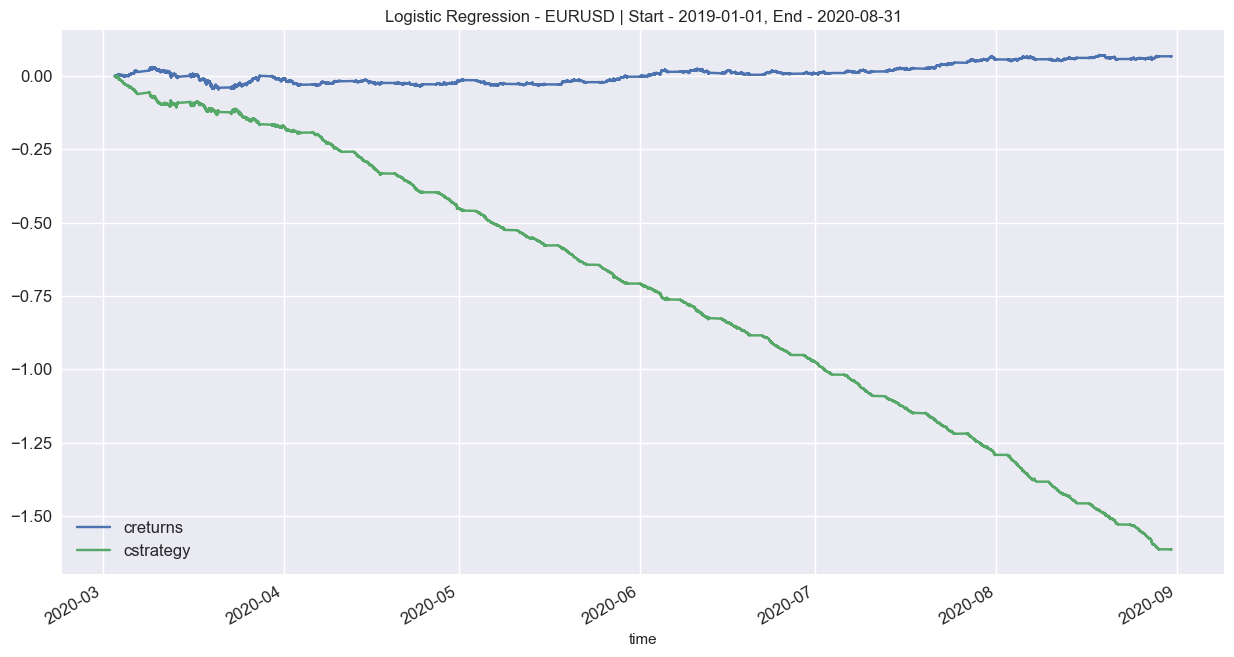

In [42]:
ml.plot_results()

In [43]:
for lags in range(1,21):
    print(lags,ml.test_strategy(0.7,lags))

1 -4.51074
2 -3.54816
3 -3.395304
4 -3.289341
5 -3.166155
6 -3.140484
7 -3.173479
8 -3.156073
9 -3.050671
10 -3.124341
11 -3.024052
12 -3.04751
13 -3.033316
14 -3.091376
15 -3.060536
16 -3.119942
17 -3.09135
18 -3.062646
19 -3.090825
20 -3.095236
